In [84]:
# add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

# #sklearnex
# from sklearnex import patch_sklearn
# patch_sklearn()
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
# StratifiedKFold
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import (accuracy_score,
                            recall_score,
                            precision_score,
                            f1_score,
                            roc_auc_score,
                            roc_curve,
                            matthews_corrcoef,
)
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
import scipy
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import cv2 as cv
from radiomics import featureextractor
from tqdm import tqdm
from IPython.display import clear_output
from sklearn.preprocessing import StandardScaler
# RandomizedSearchCV
#Import paths and patients classes
from notebooks.info import path_label, patient
import notebooks.utils as utils# PCA

In [27]:
def get_ex_included(budget_path: Path):
    """get excluded features name using the budget CV value

    Args:
        budget_path (Path): path to the csv file with the budget

    Returns:
        sequences: excluded and included features
    """
    # get the name of the features from the budget
    budget = pd.read_csv(budget_path, index_col=0)
    # change name of column
    budget.columns = ['budget']
    # get all features with values greater than 1
    excluded = budget[budget[ 'budget' ] > 1].index
    # get all other names
    included = budget[budget[ 'budget' ] <= 1].index
    
    return excluded, included

def get_features(excluded:list):
    """
    return df with features given the segmentation type and excluded features

    Args:
        stype (str): general or focal
        excluded (seq): sequence of excluded features

    Returns:
        pd.DataFrame: df with features
    """
    # get features
    features = pd.read_csv(repo_path / 'data' / 'features' / f'feat_vector.csv', index_col=0)
    # remove features in excluded list
    features = features.drop(excluded, axis=1)

    return features

def best_threshold(fpr, tpr, thresholds):
    """given the roc curve information, it returns the best threshold accoridng to the gmean

    Args:
        fpr (np.array): false positiva rate values
        tpr (np.array): true positive rate values
        thresholds (np.array): thresholds found for the ROC curve

    Returns:
        float: optimal threshold
    """
    # Calculate the G-mean
    gmean = np.sqrt(tpr * (1 - fpr))
    # Find the optimal threshold
    index = np.argmax(gmean)
    thresholdOpt = round(thresholds[index], ndigits = 4)
    # gmeanOpt = round(gmean[index], ndigits = 4)
    # fprOpt = round(fpr[index], ndigits = 4)
    # tprOpt = round(tpr[index], ndigits = 4)

    return thresholdOpt

# Traditional

In [36]:
# load info class
info = path_label()

# experiment HP
label = 'RP' # receptor type (RP, RE, ki67)

# load features# PCA
budget_path = repo_path/ 'data' / 'budget' / 'budget_ROI_and_rad.csv'
excluded, _ = get_ex_included(budget_path) # get excluded features due to their budget value
features = get_features(excluded)
print(f'The featu# RandomizedSearchCVres removed PCAare {excluded.values} beacuse their budget value is greater than 1')

The features removed are ['glcm_ClusterShade'] beacuse their budget value is greater than 1


LASSO

In [143]:
n = features.shape[0] # number of patients
p = features.shape[1] # number of features
# feature selection using lasso
print(f'The number of patients (n) is: {n}\nThe number of features (p) is: {p}')

# prepare data
y = np.asarray(info.labels_list(label))
x = np.asarray(features)

# define lasso
pipe_lasso = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', LogisticRegression(penalty='l1', solver='liblinear', class_weight=None, C=0.5, max_iter=1000))
    ])
# apply in ALL dataset
pipe_lasso.fit(x, y)
coef = pipe_lasso.named_steps['lasso'].coef_
# get the features that are not zero
features_selected = features.columns[coef[0] != 0]
print(f'The number of features selected is: {len(features_selected)}')
print(f'The features selected are: {features_selected.values}')

x = np.asarray(features[features_selected])


The number of patients (n) is: 33
The number of features (p) is: 101
The number of features selected is: 5
The features selected are: ['firstorder_Range' 'firstorder_Skewness' 'glszm_GrayLevelNonUniformity'
 'glrlm_RunEntropy' 'ngtdm_Busyness']


In [142]:
def classifier_and_grid(method, grid='normal',verbose=1, reductor_components=[1]):
  """
  Definition of the classifier grid method for the hyperparameters search.
  :param method: learning method name (SVM, random forest, etc.)
  :param grid: type of grid search given (random or normal)
  """
  n_splits = 5
  #KNN
  if(method=='KNN'):
    param_grid = {'classifier__n_neighbors': list(range(1,40))}
    pipe = Pipeline([('scaler', StandardScaler()),('classifier',KNeighborsClassifier())])
    grid = GridSearchCV(pipe, param_grid, scoring='accuracy', verbose = verbose)
    return grid
  #KNN with PCA
  elif(method=='KNN_PCA'):# PCA
    param_grid = {'reductor__n_components': reductor_components,'classifier__n_neighbors': list(range(1,30))}
    pipe = Pipeline([('scaler', StandardScaler()),('reductor',PCA()),('classifier',KNeighborsClassifier())])
    grid = GridSearchCV(pipe, param_grid, scoring='accuracy', verbose = verbose)
    return grid
  #SVM with PCA
  elif(method=='SVM_PCA'):
    if(grid=='normal'):
      param_grid = {'reductor__n_components': reductor_components,'classifier__C': [0.1, 1, 10, 100],
              'classifier__gamma': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
              'classifier__kernel': ['rbf']}
      pipe = Pipeline([('scaler', StandardScaler()),('reductor',PCA()),('classifier',SVC())])
      grid = GridSearchCV(pipe, param_grid, scoring='accuracy', cv = StratifiedKFold(n_splits=n_splits) ,verbose = verbose)
      return grid
    elif(grid=='random'):
      parameters = {'reductor__n_components': reductor_components,'classifier__C': scipy.stats.expon(scale=10), 'classifier__gamma': scipy.stats.expon(scale=.001), #Parameters for grid search
      'classifier__kernel': ['rbf'], 'classifier__class_weight':['balanced']}
      pipe = Pipeline([('scaler', StandardScaler()),('reductor',PCA()), ('classifier',SVC())]) #Definition of pipeline
      grid = RandomizedSearchCV(pipe, parameters,n_iter=20, scoring='accuracy', cv = StratifiedKFold(n_splits=n_splits) , verbose=verbose, return_train_score=False) #Random search
      return grid
  #SVM no PCA    
  elif(method=='SVM'):
    if(grid=='normal'):
      param_grid = {'classifier__C': [0.1, 1, 10, 100],
              'classifier__gamma': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
              'classifier__kernel': ['rbf'],'classifier__class_weight':['balanced']}
      pipe = Pipeline([('scaler', StandardScaler()),('classifier',SVC(probability=True))])
      grid = GridSearchCV(pipe, param_grid, scoring='accuracy', verbose = verbose)
      return grid
    elif(grid=='random'):
      parameters = {'classifier__C': scipy.stats.expon(scale=10), 'classifier__gamma': scipy.stats.expon(scale=.001), #Parameters for grid search
      'classifier__kernel': ['rbf'], 'classifier__class_weight':['balanced']}
      pipe = Pipeline([('scaler', StandardScaler()),('classifier',SVC())]) #Definition of pipeline
      grid = RandomizedSearchCV(pipe, parameters,n_iter=100, scoring='accuracy', verbose=verbose, return_train_score=False) #Random search
      return grid
  #Random forest
  elif(method=='RF'):
    param_grid = {'classifier__n_estimators': [100, 200, 400, 600, 800],}
    pipe = Pipeline([('scaler', StandardScaler()),('classifier',RandomForestClassifier())])
    grid = GridSearchCV(pipe, param_grid, scoring='accuracy', verbose = verbose)
    return grid
  #Random forest with PCA
  elif(method=='RF_PCA'):
    param_grid = {'reductor__n_components': reductor_components,'classifier__n_estimators': [100, 200, 400, 600, 800],}
    pipe = Pipeline([('scaler', StandardScaler()),('reductor',PCA()), ('classifier',RandomForestClassifier())])
    grid = GridSearchCV(pipe, param_grid, scoring='accuracy', verbose = verbose)
    return grid

In [146]:
grid = classifier_and_grid('SVM',grid='normal',verbose=0, reductor_components=[1])

# use kfold
kfold = KFold(n_splits=n)

prob_matrix = np.zeros(shape=(n, 2))
# go through each fold
counter = tqdm(total=n, desc='Folds')
best_pipes = []
for train, test in kfold.split(x, y):
    # fit
    grid.fit(x[train], y[train])
    # predict
    prob_matrix[test] = grid.predict_proba(x[test])
    # save best pipe
    best_pipes.append(grid.best_estimator_)
    # update progress bar
    counter.update(1)
# close progress bar
counter.close()

Folds: 100%|██████████| 33/33 [00:06<00:00,  5.04it/s]


The optimal threshold is: 0.6323
Accuracy: 0.6666666666666666
F1 score: 0.7441860465116279
Precision: 0.7272727272727273
Sensitivity: 0.7619047619047619
Specificity: 0.5
MCC: 0.2672612419124244


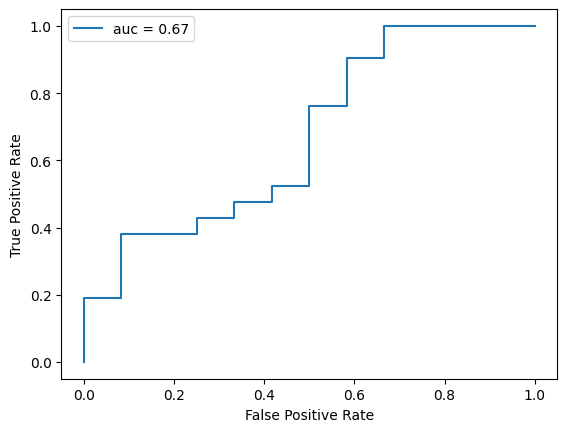

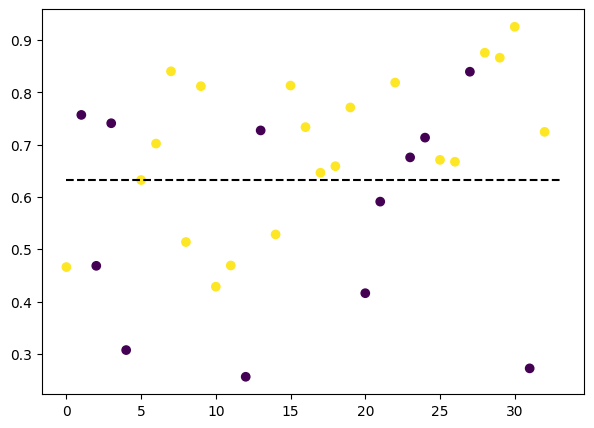

In [148]:
# show results
# get roc curve
fpr, tpr, thresholds = roc_curve(y, prob_matrix[:, 1])
# compute auc
auc = roc_auc_score(y, prob_matrix[:, 1])
# plot roc curve
plt.plot(fpr, tpr, label=f'auc = {auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# get optimal threshold
op_threshold = best_threshold(fpr, tpr, thresholds)
print(f'The optimal threshold is: {op_threshold}')
# define threshold
threshold = op_threshold
# compute metrics
# accuracy
accuracy = accuracy_score(info.labels_list(label), prob_matrix[:, 1] > threshold)
print(f'Accuracy: {accuracy}')
# F1 score
f1 = f1_score(info.labels_list(label), prob_matrix[:, 1] > threshold)
print(f'F1 score: {f1}')
# precision
precision = precision_score(info.labels_list(label), prob_matrix[:, 1] > threshold)
print(f'Precision: {precision}')
# sensitivity (recall, TPR)
sensitivity = recall_score(info.labels_list(label), prob_matrix[:, 1] > threshold)
print(f'Sensitivity: {sensitivity}')
# specificity (TNR)
specificity = recall_score(info.labels_list(label), prob_matrix[:, 1] > threshold, pos_label=0)
print(f'Specificity: {specificity}')
# MCC
mcc = matthews_corrcoef(info.labels_list(label), prob_matrix[:, 1] > threshold)
print(f'MCC: {mcc}')

# plot prediciton values, with their corresponding labels in color
plt.figure(figsize=(7,5))
plt.scatter(range(len(info.labels_list(label))), prob_matrix[:, 1],c=info.labels_list(label))
# plot threshold line
plt.plot([0, len(info.labels_list(label))], [threshold, threshold], 'k--')

Testing with budget

In [131]:
# read budget
active_budget = pd.read_csv(repo_path / 'data' / 'budget' / 'budget_computations.csv', index_col=0)
active_budget = active_budget.T[features_selected]


,firstorder_Range,firstorder_Skewness,glszm_GrayLevelNonUniformity,glrlm_RunEntropy,ngtdm_Busyness
0,89.594222,-0.061531,627.105016,0.089743,1.313265
